
--- DES standard test vector ---
Plaintext : 0123456789ABCDEF
Key       : 133457799BBCDFF1
Cipher    : 85E813540F0AB405
Expected  : 85E813540F0AB405
Test vector OK

--- ECB and CBC mode demo ---
Plaintext: b'Hello DES in VS Code Jupyter cells!'
ECB Cipher (hex): 5123BA50CC7555832082477ABA7EFCE99027552B15403815872CD992ABE438BDA76C8FF74DCA994E
ECB Decrypted: b'Hello DES in VS Code Jupyter cells!'

CBC Cipher (hex): 5123BA50CC7555837CE9DE5931E264CC751166C06DE33DD15C119DBA4CE8901B40683A8D79BD6E0E
CBC Decrypted: b'Hello DES in VS Code Jupyter cells!'

--- Visualization of rounds ---


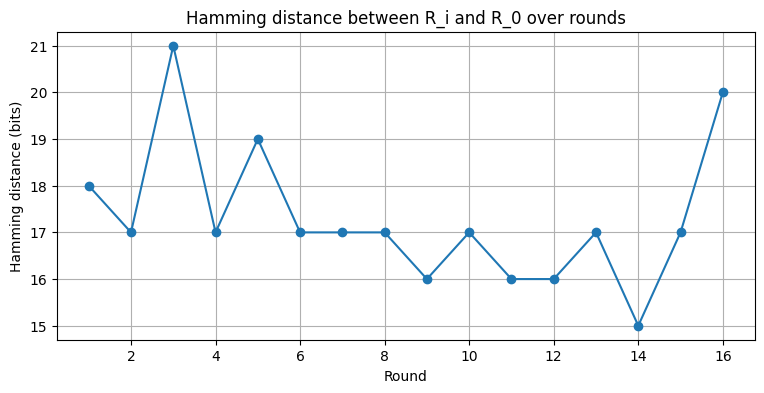


Round outputs (L||R as hex):
Round  1: F0AAF0AAEF4A6544
Round  2: EF4A6544CC017709
Round  3: CC017709A25C0BF4
Round  4: A25C0BF477220045
Round  5: 772200458A4FA637
Round  6: 8A4FA637E967CD69
Round  7: E967CD69064ABA10
Round  8: 64ABA10D5694B90
Round  9: D5694B90247CC67A
Round 10: 247CC67AB7D5D7B2
Round 11: B7D5D7B2C5783C78
Round 12: C5783C7875BD1858
Round 13: 75BD185818C3155A
Round 14: 18C3155AC28C960D
Round 15: C28C960D43423234
Round 16: 434232340A4CD995


In [1]:
# %% [markdown]
# DES (Data Encryption Standard) — Jupyter-ready implementation for VS Code
#
# Instructions:
# - Save this file in VS Code and open it. Click "Run Cell" for each cell (or use the Jupyter: Run Current File in Interactive Window).
# - Cells are separated with the "# %%" markers so VS Code treats them as notebook cells.
# - This notebook includes:
#   1. Full DES block implementation (IP/FP, key schedule, S-boxes, round function)
#   2. ECB and CBC helpers with PKCS#7 padding
#   3. Demonstration/test vectors
#   4. Simple visualizations: per-round Hamming distance and round outputs shown as hex

# %%
"""
Author: ChatGPT
Purpose: Provide a clear, runnable DES implementation suitable for learning and experimentation.
Notes:
- Not optimized for production; it's educational and explicit (tables implemented directly).
- For performance/production use, prefer vetted crypto libraries (e.g., PyCryptodome).
"""

# %%
# Standard DES tables (IP, FP, E, P, PC-1, PC-2, S-boxes, shift schedule)
IP = [
    58,50,42,34,26,18,10,2,
    60,52,44,36,28,20,12,4,
    62,54,46,38,30,22,14,6,
    64,56,48,40,32,24,16,8,
    57,49,41,33,25,17,9,1,
    59,51,43,35,27,19,11,3,
    61,53,45,37,29,21,13,5,
    63,55,47,39,31,23,15,7,
]

FP = [
    40,8,48,16,56,24,64,32,
    39,7,47,15,55,23,63,31,
    38,6,46,14,54,22,62,30,
    37,5,45,13,53,21,61,29,
    36,4,44,12,52,20,60,28,
    35,3,43,11,51,19,59,27,
    34,2,42,10,50,18,58,26,
    33,1,41,9,49,17,57,25,
]

E = [
    32,1,2,3,4,5,
    4,5,6,7,8,9,
    8,9,10,11,12,13,
    12,13,14,15,16,17,
    16,17,18,19,20,21,
    20,21,22,23,24,25,
    24,25,26,27,28,29,
    28,29,30,31,32,1,
]

P = [
    16,7,20,21,29,12,28,17,
    1,15,23,26,5,18,31,10,
    2,8,24,14,32,27,3,9,
    19,13,30,6,22,11,4,25,
]

PC1 = [
    57,49,41,33,25,17,9,
    1,58,50,42,34,26,18,
    10,2,59,51,43,35,27,
    19,11,3,60,52,44,36,
    63,55,47,39,31,23,15,
    7,62,54,46,38,30,22,
    14,6,61,53,45,37,29,
    21,13,5,28,20,12,4,
]

PC2 = [
    14,17,11,24,1,5,
    3,28,15,6,21,10,
    23,19,12,4,26,8,
    16,7,27,20,13,2,
    41,52,31,37,47,55,
    30,40,51,45,33,48,
    44,49,39,56,34,53,
    46,42,50,36,29,32,
]

SHIFTS = [1,1,2,2,2,2,2,2,1,2,2,2,2,2,2,1]

SBOXES = [
    # S1
    [
        [14,4,13,1,2,15,11,8,3,10,6,12,5,9,0,7],
        [0,15,7,4,14,2,13,1,10,6,12,11,9,5,3,8],
        [4,1,14,8,13,6,2,11,15,12,9,7,3,10,5,0],
        [15,12,8,2,4,9,1,7,5,11,3,14,10,0,6,13],
    ],
    # S2
    [
        [15,1,8,14,6,11,3,4,9,7,2,13,12,0,5,10],
        [3,13,4,7,15,2,8,14,12,0,1,10,6,9,11,5],
        [0,14,7,11,10,4,13,1,5,8,12,6,9,3,2,15],
        [13,8,10,1,3,15,4,2,11,6,7,12,0,5,14,9],
    ],
    # S3
    [
        [10,0,9,14,6,3,15,5,1,13,12,7,11,4,2,8],
        [13,7,0,9,3,4,6,10,2,8,5,14,12,11,15,1],
        [13,6,4,9,8,15,3,0,11,1,2,12,5,10,14,7],
        [1,10,13,0,6,9,8,7,4,15,14,3,11,5,2,12],
    ],
    # S4
    [
        [7,13,14,3,0,6,9,10,1,2,8,5,11,12,4,15],
        [13,8,11,5,6,15,0,3,4,7,2,12,1,10,14,9],
        [10,6,9,0,12,11,7,13,15,1,3,14,5,2,8,4],
        [3,15,0,6,10,1,13,8,9,4,5,11,12,7,2,14],
    ],
    # S5
    [
        [2,12,4,1,7,10,11,6,8,5,3,15,13,0,14,9],
        [14,11,2,12,4,7,13,1,5,0,15,10,3,9,8,6],
        [4,2,1,11,10,13,7,8,15,9,12,5,6,3,0,14],
        [11,8,12,7,1,14,2,13,6,15,0,9,10,4,5,3],
    ],
    # S6
    [
        [12,1,10,15,9,2,6,8,0,13,3,4,14,7,5,11],
        [10,15,4,2,7,12,9,5,6,1,13,14,0,11,3,8],
        [9,14,15,5,2,8,12,3,7,0,4,10,1,13,11,6],
        [4,3,2,12,9,5,15,10,11,14,1,7,6,0,8,13],
    ],
    # S7
    [
        [4,11,2,14,15,0,8,13,3,12,9,7,5,10,6,1],
        [13,0,11,7,4,9,1,10,14,3,5,12,2,15,8,6],
        [1,4,11,13,12,3,7,14,10,15,6,8,0,5,9,2],
        [6,11,13,8,1,4,10,7,9,5,0,15,14,2,3,12],
    ],
    # S8
    [
        [13,2,8,4,6,15,11,1,10,9,3,14,5,0,12,7],
        [1,15,13,8,10,3,7,4,12,5,6,11,0,14,9,2],
        [7,11,4,1,9,12,14,2,0,6,10,13,15,3,5,8],
        [2,1,14,7,4,10,8,13,15,12,9,0,3,5,6,11],
    ],
]

# %%
# Bit and permutation helpers

def permute(block: int, table: list, out_bits: int = None) -> int:
    """Apply permutation table (table entries 1-indexed positions within a 64-bit space).
    Return integer whose bit-length equals len(table) unless out_bits specified."""
    out = 0
    for pos in table:
        # pos ranges 1..64 (IP/FP) or 1..32 (for others relative to 32-bit blocks); we always treat
        # the source block as left-aligned into a 64-bit window when referencing positions above 32.
        bit = (block >> (64 - pos)) & 1
        out = (out << 1) | bit
    if out_bits is not None:
        out &= (1 << out_bits) - 1
    return out


def left_rotate(val: int, n: int, bits: int) -> int:
    return ((val << n) & ((1 << bits) - 1)) | (val >> (bits - n))

# %%
# Key schedule (generate 16 48-bit subkeys)

def generate_subkeys(key64: int) -> list:
    # PC-1: drop parity bits -> 56 bits
    key56 = 0
    for pos in PC1:
        key56 = (key56 << 1) | ((key64 >> (64 - pos)) & 1)
    C = (key56 >> 28) & ((1 << 28) - 1)
    D = key56 & ((1 << 28) - 1)
    subkeys = []
    for shift in SHIFTS:
        C = left_rotate(C, shift, 28)
        D = left_rotate(D, shift, 28)
        CD = (C << 28) | D
        # Apply PC-2
        sub = 0
        for pos in PC2:
            sub = (sub << 1) | ((CD >> (56 - pos)) & 1)
        subkeys.append(sub)
    return subkeys

# %%
# Feistel function f(R, K)

def sbox_substitution(six: int, box: int) -> int:
    row = ((six & 0b100000) >> 4) | (six & 1)
    col = (six >> 1) & 0b1111
    return SBOXES[box][row][col]


def feistel(R: int, subkey: int) -> int:
    # Expand to 48 bits
    E_R = 0
    for pos in E:
        E_R = (E_R << 1) | ((R >> (32 - pos)) & 1)
    x = E_R ^ subkey
    out32 = 0
    for i in range(8):
        six = (x >> (42 - 6*i)) & 0x3F
        val = sbox_substitution(six, i)
        out32 = (out32 << 4) | val
    # P-permutation
    permuted = 0
    for pos in P:
        permuted = (permuted << 1) | ((out32 >> (32 - pos)) & 1)
    return permuted

# %%
# Single-block encrypt/decrypt (64-bit)

def des_block_encrypt(block64: int, subkeys: list) -> int:
    permuted = 0
    for pos in IP:
        permuted = (permuted << 1) | ((block64 >> (64 - pos)) & 1)
    L = (permuted >> 32) & 0xFFFFFFFF
    R = permuted & 0xFFFFFFFF
    round_outputs = []  # store (L,R) for visualization
    for i in range(16):
        newL = R
        newR = L ^ feistel(R, subkeys[i])
        L, R = newL, newR
        round_outputs.append((L, R))
    preout = (R << 32) | L
    cipher = 0
    for pos in FP:
        cipher = (cipher << 1) | ((preout >> (64 - pos)) & 1)
    return cipher, round_outputs


def des_block_decrypt(block64: int, subkeys: list) -> int:
    # apply subkeys reversed
    rev = list(reversed(subkeys))
    cipher, _ = des_block_encrypt(block64, rev)
    return cipher

# %%
# Byte helpers and PKCS#7 padding

def bytes_to_int(b: bytes) -> int:
    return int.from_bytes(b, 'big')


def int_to_bytes(i: int, length: int) -> bytes:
    return i.to_bytes(length, 'big')


def pad_pkcs7(data: bytes, block_size: int = 8) -> bytes:
    pad_len = block_size - (len(data) % block_size)
    if pad_len == 0:
        pad_len = block_size
    return data + bytes([pad_len]) * pad_len


def unpad_pkcs7(data: bytes) -> bytes:
    if not data:
        raise ValueError('Empty data for unpadding')
    pad_len = data[-1]
    if pad_len < 1 or pad_len > 8:
        raise ValueError('Invalid padding')
    if data[-pad_len:] != bytes([pad_len]) * pad_len:
        raise ValueError('Bad PKCS#7 padding')
    return data[:-pad_len]

# %%
# ECB and CBC modes

def des_encrypt_ecb(data: bytes, key64: int) -> bytes:
    subkeys = generate_subkeys(key64)
    data_p = pad_pkcs7(data, 8)
    out = bytearray()
    for i in range(0, len(data_p), 8):
        block = bytes_to_int(data_p[i:i+8])
        cipher_block, _ = des_block_encrypt(block, subkeys)
        out.extend(int_to_bytes(cipher_block, 8))
    return bytes(out)


def des_decrypt_ecb(cipher: bytes, key64: int) -> bytes:
    subkeys = generate_subkeys(key64)
    out = bytearray()
    for i in range(0, len(cipher), 8):
        block = bytes_to_int(cipher[i:i+8])
        plain_block = des_block_decrypt(block, subkeys)
        out.extend(int_to_bytes(plain_block, 8))
    return unpad_pkcs7(bytes(out))


def des_encrypt_cbc(data: bytes, key64: int, iv: bytes) -> bytes:
    if len(iv) != 8:
        raise ValueError('IV must be 8 bytes')
    subkeys = generate_subkeys(key64)
    data_p = pad_pkcs7(data, 8)
    out = bytearray()
    prev = bytes_to_int(iv)
    for i in range(0, len(data_p), 8):
        block = bytes_to_int(data_p[i:i+8]) ^ prev
        cipher_block, _ = des_block_encrypt(block, subkeys)
        out.extend(int_to_bytes(cipher_block, 8))
        prev = cipher_block
    return bytes(out)


def des_decrypt_cbc(cipher: bytes, key64: int, iv: bytes) -> bytes:
    if len(iv) != 8:
        raise ValueError('IV must be 8 bytes')
    subkeys = generate_subkeys(key64)
    out = bytearray()
    prev = bytes_to_int(iv)
    for i in range(0, len(cipher), 8):
        block = bytes_to_int(cipher[i:i+8])
        plain_block = des_block_decrypt(block, subkeys) ^ prev
        out.extend(int_to_bytes(plain_block, 8))
        prev = block
    return unpad_pkcs7(bytes(out))

# %% [markdown]
# Demos and visualization helpers

# %%
import matplotlib.pyplot as plt


def hexstr_to_int(h: str) -> int:
    return int(h, 16)


def int_to_hex(i: int, w: int) -> str:
    return f"{i:0{w}X}"


def demo_test_vector():
    pt_hex = '0123456789ABCDEF'
    key_hex = '133457799BBCDFF1'
    expected_ct = '85E813540F0AB405'
    pt = hexstr_to_int(pt_hex)
    key = hexstr_to_int(key_hex)
    subkeys = generate_subkeys(key)
    ct, rounds = des_block_encrypt(pt, subkeys)
    print('Plaintext :', pt_hex)
    print('Key       :', key_hex)
    print('Cipher    :', int_to_hex(ct, 16))
    print('Expected  :', expected_ct)
    assert int_to_hex(ct, 16) == expected_ct, 'Test vector failed'
    dec = des_block_decrypt(ct, subkeys)
    assert dec == pt, 'Decrypt mismatch'
    print('Test vector OK')
    return rounds

# %%
def visualize_rounds(pt_hex='0123456789ABCDEF', key_hex='133457799BBCDFF1'):
    pt = hexstr_to_int(pt_hex)
    key = hexstr_to_int(key_hex)
    subkeys = generate_subkeys(key)
    ct, rounds = des_block_encrypt(pt, subkeys)
    # rounds is list of (L,R) after each round
    # compute Hamming distance between R after each round and original R0
    # Also display round outputs
    initial_permuted = 0
    for pos in IP:
        initial_permuted = (initial_permuted << 1) | ((pt >> (64 - pos)) & 1)
    L0 = (initial_permuted >> 32) & 0xFFFFFFFF
    R0 = initial_permuted & 0xFFFFFFFF
    ham = []
    labels = []
    round_hex = []
    for i, (L, R) in enumerate(rounds, start=1):
        # represent combined L||R as 64-bit pre-swap representation (for visibility)
        combined = (L << 32) | R
        # Hamming distance between this R and R0
        x = R ^ R0
        hd = x.bit_count()
        ham.append(hd)
        labels.append(f'R{i}')
        round_hex.append(int_to_hex(combined, 8))
    # Plot Hamming distances
    plt.figure(figsize=(9,4))
    plt.plot(range(1,17), ham, marker='o')
    plt.title('Hamming distance between R_i and R_0 over rounds')
    plt.xlabel('Round')
    plt.ylabel('Hamming distance (bits)')
    plt.grid(True)
    plt.show()

    # Print round hex outputs
    print('\nRound outputs (L||R as hex):')
    for i, hx in enumerate(round_hex, start=1):
        print(f'Round {i:2d}: {hx}')

# %%
# ECB / CBC demonstration

def demo_modes():
    key_hex = '133457799BBCDFF1'
    key = hexstr_to_int(key_hex)
    pt = b"Hello DES in VS Code Jupyter cells!"
    print('Plaintext:', pt)
    ct = des_encrypt_ecb(pt, key)
    print('ECB Cipher (hex):', ct.hex().upper())
    dt = des_decrypt_ecb(ct, key)
    print('ECB Decrypted:', dt)
    iv = b'\x00' * 8
    ct2 = des_encrypt_cbc(pt, key, iv)
    print('\nCBC Cipher (hex):', ct2.hex().upper())
    dt2 = des_decrypt_cbc(ct2, key, iv)
    print('CBC Decrypted:', dt2)

# %% [markdown]
# Run quick demos

# %%
if __name__ == '__main__':
    print('\n--- DES standard test vector ---')
    rounds = demo_test_vector()
    print('\n--- ECB and CBC mode demo ---')
    demo_modes()
    print('\n--- Visualization of rounds ---')
    try:
        visualize_rounds()
    except Exception as e:
        print('Visualization failed:', e)

# %% [markdown]
# Tips for using this file in VS Code
# - Save as `DES_Jupyter_in_VSCode.py`, right-click and choose "Run Current File in Interactive Window" or run cells individually.
# - To export as a real `.ipynb`, open the interactive window and use the command palette to export.
# - If you want richer visualizations (bit-level heatmaps), tell me and I'll add a second visualization cell.
